# README

* For each observation, divid the sequence to a list of sequences of the same size using a moving window of a fixed size with a given step.

In [73]:
%matplotlib inline
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.models import model_from_json
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt

In [2]:
original_features=['scalar.fx', 'scalar.fy', 'scalar.fz','scalar.tx', 'scalar.ty','scalar.tz','scalar.current','scalar.ang_vel']

# Load data

In [3]:
%%time
dfs = [pd.read_csv(filename, sep=',',header=0) for filename in glob.glob("data/*.csv")]

CPU times: user 13.5 s, sys: 676 ms, total: 14.2 s
Wall time: 14.2 s


## Get the longest and shortest sequences

In [4]:
longest_len = max(dfs, key=lambda df: df.shape[0]).shape[0]
shortest_len = min(dfs, key=lambda df: df.shape[0]).shape[0]
print("shortest_len={}, longest_len={}".format( shortest_len, longest_len) )

shortest_len=535, longest_len=4479


# Create windows

* Windows are equal length comprising of N, eg. 32, time frames.
* A wavelet is obtained by using a moving window of length N.
* The beginning of the moving window starts M, e.g. 8, time frames behind the beginning of the previous window.

In [5]:
def rolling(df, original_features=original_features, 
            frames=32, steps=8, type_class='class.type', stage_class='class.stage'):
    """
    df - dataframe
    """
    starts = np.arange(0, len(df)-frames, steps)[:-1] # an array of start locations    
    x = np.zeros((len(starts), frames, len(original_features)))
    y = np.zeros((len(starts), 1))
    y2 = np.zeros((len(starts), 1))
    
    for i in np.arange(len(starts)):
        start = starts[i]
        x[i] = df.iloc[start:start+frames].as_matrix(columns=original_features)
        y[i] = df[type_class].iloc[start + steps]
        y2[i] = df[stage_class].iloc[start + steps]

    return x, y, y2

In [6]:
def moving_windows(dfs, frames=32, steps=8):
    """split each observation to a tuple of X, Y, Y2 using a moving window"""

    X=None; Y=None; Y2=None
    for df in dfs:
        x, y, y2 = rolling(df, original_features,frames, steps)
        if X is None:
            X = x.copy(); Y = y.copy(); Y2 = y2.copy();
        else:
            X = np.append(X, x, axis=0)
            Y = np.append(Y, y, axis=0)
            Y2= np.append(Y2, y2, axis=0)
    return X, Y, Y2

## save or load window-based data

In [7]:
%%time
frames = 32
steps = 8

import os.path
file_path = 'data_win/f32s8.npz'
if os.path.exists(file_path):
    loaded = np.load(file_path)
    X = loaded['X']
    Y = loaded['Y']
    Y2 = loaded['Y2']
else:
    X, Y, Y2 = moving_windows(dfs, frames, steps)
    np.savez_compressed(file_path, X=X, Y=Y, Y2=Y2)

CPU times: user 4.21 s, sys: 222 ms, total: 4.43 s
Wall time: 4.43 s


#### Plot a histogram of types

(array([      0.,  433720.,   82458.,   21594.,    3516.,    2264.,
           6397.,    3243.]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 <a list of 8 Patch objects>)

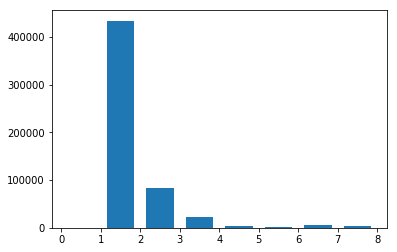

In [8]:
plt.hist(Y, bins=np.arange(len(np.unique(Y))+2), rwidth=.7, align='mid')

In [9]:
np.unique(Y)

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.])

#### Plot a histogram of stages

(array([  42954.,   24250.,   30095.,   76401.,  322035.,   10290.,
           2103.,     952.,    2786.,   41326.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 10 Patch objects>)

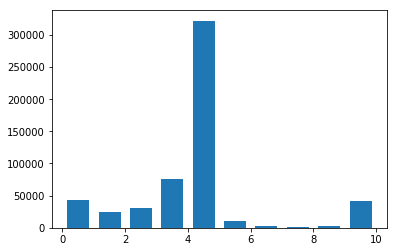

In [10]:
plt.hist(Y2, bins=np.arange(len(np.unique(Y2))+1), rwidth=.7, align='mid')

In [11]:
np.unique(Y2)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.])

# One hot encoding of dependent variables

In [12]:
offset = 1
num_classes = len(np.unique(Y))
Y_encoded=to_categorical(Y-offset, num_classes=num_classes)
Y_encoded.shape

(553192, 7)

In [13]:
offset = 0
num_classes = len(np.unique(Y2))
Y2_encoded=to_categorical(Y2, num_classes=num_classes)
Y2_encoded.shape

(553192, 10)

# Split the data to train, validation and test

* train = 60%
* validation = 20%
* test = 20%

In [14]:
x_train, x_validate, x_test = np.split(X, [int(.6*len(X)), int(.8*len(X))])
y_train, y_validate, y_test = np.split(Y_encoded, [int(.6*len(Y_encoded)), int(.8*len(Y_encoded))])
y2_train, y2_validate, y2_test = np.split(Y2_encoded, [int(.6*len(Y2_encoded)), int(.8*len(Y2_encoded))])

print (x_train.shape, y_train.shape, y2_train.shape)
print (x_validate.shape, y_validate.shape, y2_validate.shape)
print (x_test.shape, y_test.shape, y2_test.shape)

((331915, 32, 8), (331915, 7), (331915, 10))
((110638, 32, 8), (110638, 7), (110638, 10))
((110639, 32, 8), (110639, 7), (110639, 10))


### Histogram of classes in training data

(array([ 259741.,   47704.,   13477.,    2275.,    1808.,    4118.,    2792.]),
 array([0, 1, 2, 3, 4, 5, 6, 7]),
 <a list of 7 Patch objects>)

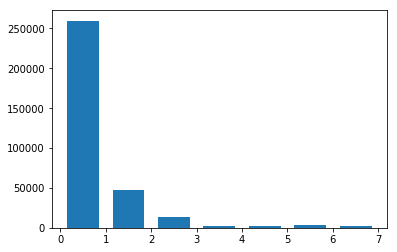

In [15]:
labels=np.argmax(y_train, axis=1)
plt.hist(labels, bins=np.arange(len(np.unique(labels))+1), rwidth=.7, align='mid')

(array([  25840.,   15718.,   18270.,   43892.,  193170.,    6269.,
           1670.,     605.,    1739.,   24742.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 10 Patch objects>)

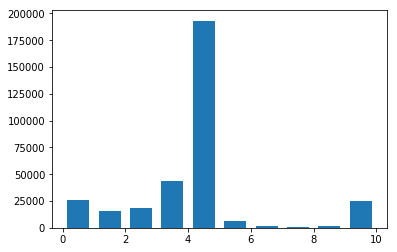

In [44]:
labels=np.argmax(y2_train, axis=1)
plt.hist(labels, bins=np.arange(len(np.unique(labels))+1), rwidth=.7, align='mid')

# Train a type classification model with LSTM

In [74]:
%%time

timesteps = x_train.shape[1]
data_dim = x_train.shape[2]
num_epochs = 7
batch_size = 64
num_classes = y_train.shape[1]

layers = [LSTM(batch_size, return_sequences=True,
               input_shape=(timesteps, data_dim)), 
         LSTM(batch_size, return_sequences=True),
         LSTM(batch_size),
         Dense(num_classes, activation='softmax')]

# expected input data shape: (batch_size, timesteps, data_dim)
model = Sequential(layers)

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# checkpoint
filepath="models/type_lstm_v2.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit(x_train, y_train,
                    batch_size=batch_size, epochs=num_epochs,
                    validation_data=(x_validate, y_validate),
                    callbacks=callbacks_list)

Train on 331915 samples, validate on 110638 samples
Epoch 1/7
331915/331915 [==============================] - 377s 1ms/step - loss: 0.2619 - acc: 0.9207 - val_loss: 0.4437 - val_acc: 0.8799
Epoch 2/7
331915/331915 [==============================] - 375s 1ms/step - loss: 0.1762 - acc: 0.9485 - val_loss: 0.3585 - val_acc: 0.9071
Epoch 3/7
331915/331915 [==============================] - 375s 1ms/step - loss: 0.1534 - acc: 0.9558 - val_loss: 0.4484 - val_acc: 0.9016
Epoch 4/7
331915/331915 [==============================] - 376s 1ms/step - loss: 0.1431 - acc: 0.9591 - val_loss: 0.4799 - val_acc: 0.8975
Epoch 5/7
331915/331915 [==============================] - 379s 1ms/step - loss: 0.1377 - acc: 0.9604 - val_loss: 0.4524 - val_acc: 0.9068
Epoch 6/7
331915/331915 [==============================] - 382s 1ms/step - loss: 0.1339 - acc: 0.9616 - val_loss: 0.5048 - val_acc: 0.9015
Epoch 7/7
331915/331915 [==============================] - 379s 1ms/step - loss: 0.1303 - acc: 0.9628 - val_loss: 

## View training history

In [75]:
def plot_history(history):
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validate'], loc='upper left')
    plt.show()
    
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validate'], loc='upper left')
    plt.show()

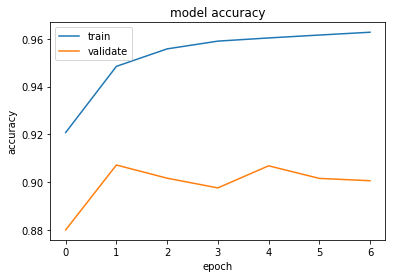

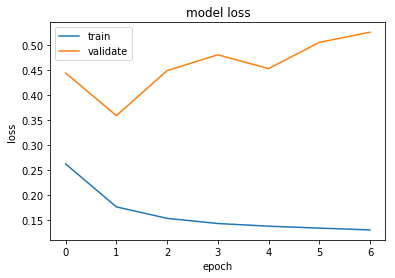

In [76]:
plot_history(history)

## Save the model
include the model and its weights

In [70]:
def save_model(model, model_filename="models/type_lstm_v2.json", weights_file_name=None):
    # serialize model to JSON
    model_json = model.to_json()
    with open(model_filename, "w") as json_file:
        json_file.write(model_json)
    print("Saved the model to disk")    
    
    # serialize weights to HDF5
    if weights_file_name is not None:
        model.save_weights(weights_file_name)
        print("Saved the model weights to disk")

In [71]:
save_model(model, "models/type_lstm_v2.json")

Saved the model to disk


## Use the saved model to predict on new data

In [77]:
def load_model(model_filename='models/type_lstm_v2.json', weights_filename="models/type_lstm_v2.h5"):
    # load json and create model
    json_file = open(model_filename, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(weights_filename)
    print("Loaded the model from disk")
    
    return loaded_model

In [78]:
model = load_model('models/type_lstm_v2.json', "models/type_lstm_v2.h5")

Loaded the model from disk


## We need to compile the model before use it

In [79]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

## Evaluation

display labels for the scalar outputs

In [80]:
model.metrics_names

['loss', 'acc']

In [81]:
score = model.evaluate(x_test, y_test, batch_size=64)

110639/110639 [==============================] - 29s 258us/step


In [82]:
score

[0.49502641845624379, 0.88362150778766269]

## Predict

**Remember** The classes are 0 to 6 instead of 1 to 7.

In [83]:
%%time
y_hat = model.predict(x_test)

CPU times: user 55.8 s, sys: 818 ms, total: 56.6 s
Wall time: 52.7 s


In [84]:
x_test.shape

(110639, 32, 8)

### Prediction results are the probability of each class

In [85]:
y_hat.shape

(110639, 7)

In [86]:
y_hat

array([[  9.05662775e-01,   9.26854759e-02,   8.41933303e-04, ...,
          1.43964544e-05,   3.81146237e-04,   9.13686381e-05],
       [  8.93113971e-01,   1.04713507e-01,   1.13296497e-03, ...,
          8.88536033e-06,   2.53188802e-04,   8.73065001e-05],
       [  5.97273409e-01,   3.98178577e-01,   2.08383496e-03, ...,
          1.81556345e-04,   3.86935892e-04,   2.46028940e-04],
       ..., 
       [  9.99139071e-01,   1.91041676e-04,   2.45261799e-05, ...,
          7.61168106e-09,   5.39919020e-05,   3.69164059e-06],
       [  9.99183714e-01,   1.81071009e-04,   2.55907726e-05, ...,
          8.04192180e-09,   5.89615593e-05,   3.63033246e-06],
       [  9.99221444e-01,   1.73877168e-04,   2.64798855e-05, ...,
          7.96048649e-09,   6.12487638e-05,   3.63211802e-06]], dtype=float32)

# Train a stage classification model with LSTM

In [89]:
%%time

timesteps = x_train.shape[1]
data_dim = x_train.shape[2]
num_epochs = 10
batch_size = 64
num_classes = y2_train.shape[1]

layers = [LSTM(batch_size, return_sequences=True,
               input_shape=(timesteps, data_dim)), 
         LSTM(batch_size, return_sequences=True),
         LSTM(batch_size),
         Dense(num_classes, activation='softmax')]

# expected input data shape: (batch_size, timesteps, data_dim)
model = Sequential(layers)

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# checkpoint
filepath="models/stage_lstm_v2.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit(x_train, y2_train,
                    batch_size=batch_size, epochs=num_epochs,
                    validation_data=(x_validate, y2_validate),
                    callbacks=callbacks_list)

Train on 331915 samples, validate on 110638 samples
Epoch 1/10
331915/331915 [==============================] - 378s 1ms/step - loss: 0.2494 - acc: 0.9208 - val_loss: 0.3435 - val_acc: 0.9164
Epoch 2/10
331915/331915 [==============================] - 376s 1ms/step - loss: 0.1345 - acc: 0.9561 - val_loss: 0.3352 - val_acc: 0.9201
Epoch 3/10
331915/331915 [==============================] - 377s 1ms/step - loss: 0.1149 - acc: 0.9621 - val_loss: 0.3767 - val_acc: 0.9130
Epoch 4/10
331915/331915 [==============================] - 379s 1ms/step - loss: 0.1055 - acc: 0.9653 - val_loss: 0.3191 - val_acc: 0.9231
Epoch 5/10
331915/331915 [==============================] - 377s 1ms/step - loss: 0.0996 - acc: 0.9674 - val_loss: 0.3097 - val_acc: 0.9282
Epoch 6/10
331915/331915 [==============================] - 378s 1ms/step - loss: 0.0959 - acc: 0.9683 - val_loss: 0.3552 - val_acc: 0.9286
Epoch 7/10
331915/331915 [==============================] - 377s 1ms/step - loss: 0.0923 - acc: 0.9698 - val

## View training history

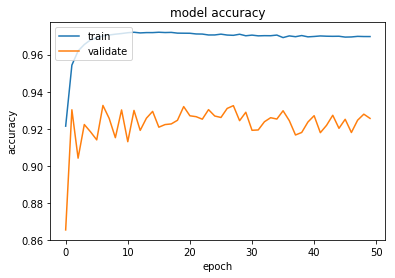

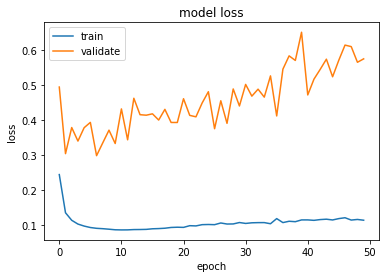

In [55]:
plot_history(history)

## Save the model
include the model and its weights

In [ ]:
save_model(model, "models/stage_lstm_v2.json")

## Use the saved model to predict on new data

In [56]:
model = load_model('models/stage_lstm_v2.json', "models/stage_lstm_v2.h5")

Loaded the model from disk


## We need to compile the model before use it

In [57]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

## Evaluation

display labels for the scalar outputs

In [58]:
model.metrics_names

['loss', 'acc']

In [90]:
score = model.evaluate(x_test, y2_test, batch_size=64)

110639/110639 [==============================] - 28s 253us/step


In [91]:
score

[0.45807175594517668, 0.91693706559277655]

## Predict

In [61]:
%%time
y_hat = model.predict(x_test)

CPU times: user 56.7 s, sys: 911 ms, total: 57.7 s
Wall time: 53.6 s


In [62]:
x_test.shape

(110639, 32, 8)

### Prediction results are the probability of each class

In [63]:
y_hat.shape

(110639, 10)

In [64]:
y_hat

array([[  2.51026023e-16,   3.98357427e-14,   8.81139672e-19, ...,
          2.24416124e-12,   1.03359237e-12,   1.31630046e-07],
       [  4.09898920e-11,   7.00972222e-08,   3.76447429e-10, ...,
          2.89564306e-09,   1.72894303e-08,   4.72029114e-06],
       [  3.97504820e-08,   4.27433406e-05,   1.10471683e-06, ...,
          7.20999196e-07,   2.19314115e-05,   6.71502843e-04],
       ..., 
       [  1.76050021e-14,   3.55573211e-25,   7.56801721e-27, ...,
          9.43718615e-18,   8.80834988e-17,   1.00000000e+00],
       [  1.43966565e-14,   3.56362170e-25,   7.73883256e-27, ...,
          7.58872120e-18,   6.61552055e-17,   1.00000000e+00],
       [  1.41319129e-14,   3.57204649e-25,   7.98707954e-27, ...,
          7.51147742e-18,   6.44732627e-17,   1.00000000e+00]], dtype=float32)